<a href="https://colab.research.google.com/github/raphael-fawaz/Financial-Markets-Analysis-and-Prediction/blob/Bi-LSTM-(Dow-Jones-%26-Nasdaq)---Close-Price/LSTM_(EGX30)_Multiple_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM (EGX30) - Multiple feature

In [ ]:
import pandas as pd
import numpy as np
import io

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pandas.plotting import lag_plot

In [ ]:
EGX30 = pd.read_csv('EGX 30 Data June.csv',parse_dates=['Date'])

In [ ]:
EGX30.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-06-05,"26,634.30","26,915.46","26,915.46","26,245.33",240.86M,-1.26%
1,2024-06-04,"26,973.00","26,852.33","27,158.65","26,852.33",352.59M,0.52%
2,2024-06-03,"26,834.47","26,869.85","27,003.04","26,760.84",267.86M,-0.13%
3,2024-06-02,"26,869.85","26,922.76","27,140.20","26,753.70",225.28M,-0.20%
4,2024-05-30,"26,922.76","27,089.68","27,116.25","26,683.97",352.59M,-0.62%


### Data engineering

In [ ]:
def convert_volume_to_float(volume_str):
    if pd.isna(volume_str):
        return np.nan
    else:
        return float(volume_str[:-1]) * 1e6

def convert_change_to_float(change_str):
    if pd.isna(change_str):
        return np.nan
    else:
        return float(change_str[:-1]) /100

In [ ]:
EGX30['Date'] = pd.to_datetime(EGX30['Date'])

EGX30 = EGX30.dropna()

num_cols = ['Price', 'Open', 'High', 'Low']
for col in num_cols:
    EGX30[col] = EGX30[col].str.replace(',', '').astype(float)

EGX30['Vol.'] = EGX30['Vol.'].apply(convert_volume_to_float)
EGX30['Change %']= EGX30['Change %'].apply(convert_change_to_float)

# Set the 'Date' column as the index
EGX30.set_index('Date', inplace=True)

#Change the name of the price column to close.
EGX30.rename(columns={'Price': 'Close'}, inplace=True)

EGX30.head()

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-05,26634.30,26915.46,26915.46,26245.33,240860000.0,-0.0126
2024-06-04,26973.00,26852.33,27158.65,26852.33,352590000.0,0.0052
2024-06-03,26834.47,26869.85,27003.04,26760.84,267860000.0,-0.0013
2024-06-02,26869.85,26922.76,27140.20,26753.70,225280000.0,-0.0020
2024-05-30,26922.76,27089.68,27116.25,26683.97,352590000.0,-0.0062


In [ ]:
EGX30 = EGX30[::-1]

In [ ]:
EGX30.head()

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2009-03-01,3647.02,3597.56,3648.15,3588.01,43850000.0,0.0137
2009-03-02,3584.86,3640.55,3641.19,3584.86,46910000.0,-0.0170
2009-03-03,3517.33,3524.81,3533.41,3494.95,57010000.0,-0.0188
2009-03-04,3559.09,3524.63,3562.48,3524.63,68900000.0,0.0119
2009-03-05,3575.93,3566.55,3605.23,3565.60,54810000.0,0.0047


## Normalizing

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
egx30_scaled = scaler.fit_transform(EGX30)

## Creating Sequences

In [ ]:
EGX30['Close']

Date
2009-03-01     3647.02
2009-03-02     3584.86
2009-03-03     3517.33
2009-03-04     3559.09
2009-03-05     3575.93
                ...   
2024-05-30    26922.76
2024-06-02    26869.85
2024-06-03    26834.47
2024-06-04    26973.00
2024-06-05    26634.30
Name: Close, Length: 3682, dtype: float64

In [ ]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length, 0])  # The 'Close' price is at first column
    return np.array(sequences), np.array(labels)

In [ ]:
seq_length = 60  # Use 60 days of data to predict the next day's price
egx30_sequences, egx30_labels = create_sequences(egx30_scaled, seq_length)

# Determine the index to split the data for the test set (last 60 days)
test_size = 60
train_sequences = egx30_sequences[:-test_size]
test_sequences = egx30_sequences[-test_size:]
train_labels = egx30_labels[:-test_size]
test_labels = egx30_labels[-test_size:]

print(f"Training sequences shape: {train_sequences.shape}")
print(f"Test sequences shape: {test_sequences.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training sequences shape: (3562, 60, 6)
Test sequences shape: (60, 60, 6)
Training labels shape: (3562,)
Test labels shape: (60,)


## Single LSTM Layer with multiple features

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(seq_length, EGX30.shape[1])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(train_sequences, train_labels, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
90/90 [==============================] - 4s 26ms/step - loss: 0.0025 - val_loss: 7.1854e-04
Epoch 2/20
90/90 [==============================] - 2s 19ms/step - loss: 6.4588e-04 - val_loss: 0.0018
Epoch 3/20
90/90 [==============================] - 2s 19ms/step - loss: 6.0580e-04 - val_loss: 0.0013
Epoch 4/20
90/90 [==============================] - 2s 20ms/step - loss: 4.5431e-04 - val_loss: 2.4995e-04
Epoch 5/20
90/90 [==============================] - 2s 19ms/step - loss: 4.0031e-04 - val_loss: 2.6348e-04
Epoch 6/20
90/90 [==============================] - 2s 20ms/step - loss: 3.7760e-04 - val_loss: 1.7402e-04
Epoch 7/20
90/90 [==============================] - 2s 19ms/step - loss: 3.3026e-04 - val_loss: 2.7632e-04
Epoch 8/20
90/90 [==============================] - 2s 19ms/step - loss: 3.3171e-04 - val_loss: 2.5703e-04
Epoch 9/20
90/90 [==============================] - 2s 19ms/step - loss: 2.7456e-04 - val_loss: 2.7279e-04
Epoch 10/20
90/90 [==============================

2/2 [==============================] - 0s 9ms/step
Root Mean Squared Error: 0.05676433765430233


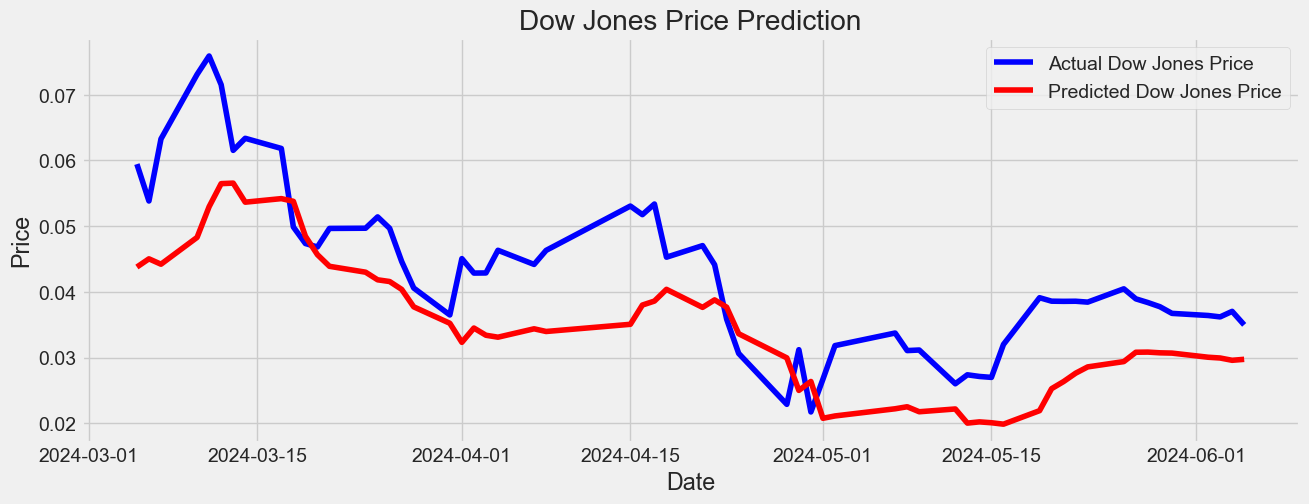

In [ ]:
# Predict on the test data
predictions = model.predict(test_sequences)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_labels, predictions))
print(f'Root Mean Squared Error: {rmse}')


# Inverse transform the predictions and test labels
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], EGX30.shape[1]-1)), predictions), axis=1))[:, -1]
test_labels = scaler.inverse_transform(np.concatenate((np.zeros((test_labels.shape[0], EGX30.shape[1]-1)), test_labels.reshape(-1, 1)), axis=1))[:, -1]

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(EGX30.index[-len(test_labels):], test_labels, color='blue', label='Actual Dow Jones Price')
plt.plot(EGX30.index[-len(test_labels):], predictions, color='red', label='Predicted Dow Jones Price')
plt.title('Dow Jones Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()